# 目標
- 小さなデータでsubmissionを目指す.

In [1]:
import sys
sys.path.append("../yandex/")
#sys.path.append("../lib/")
import os
import pandas as pd

import utils
import scoring
import calc_var as cv

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import catboost
import swifter

from hyperopt import fmin, tpe, hp, rand
import optuna

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
%load_ext autoreload

pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 200)

Using TensorFlow backend.
/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# データの準備

In [2]:
DATA_PATH = "../your_data_dir/"

In [3]:
train, test = utils.load_data_csv(
    DATA_PATH, utils.SIMPLE_FEATURE_COLUMNS)

/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



## event数を絞る

In [4]:
#sample = train.sample(1000000)
sample = train.copy()

In [5]:
sample.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  avg_cs[3]  \
0      47      31      13      15   2.000000   1.580645   1.153846   1.133333   
1      92      19      11      26   2.750000   2.789474   1.363636   1.230769   
2     100      21      11      12   2.930000   2.428571   1.181818   1.083333   
3      74      27      13      20   3.067568   2.518518   1.923077   1.300000   
4      18      22       8       8   1.833333   1.954546   1.125000   1.750000   

   ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  MatchedHit_TYPE[2]  \
0     8                   2                   2                   2   
1     8                   2                   2                   2   
2     8                   2                   2                   2   
3     8                   2                   2                   2   
4     8                   2                   2                   2   

   MatchedHit_TYPE[3]  MatchedHit_X[0]  MatchedHit_X[1]  MatchedHit_X[2]  \
0                   2       -2685.0800         -2954.30         -3140.97   
1                   1         739.5500           852.51           827.00   
2                   2       -1595.1300         -1748.45         -1933.97   
3                   2       -1708.8291         -1816.95         -1933.97   
4                   2       -1504.6300         -1651.95         -1815.97   

   MatchedHit_X[3]  MatchedHit_Y[0]  MatchedHit_Y[1]  MatchedHit_Y[2]  \
0         -3609.17       1373.34810       1481.26220       1590.39750   
1           758.72       2387.72220       2575.97460       2764.19650   
2         -2066.67       -318.64474       -344.52970       -221.99326   
3         -2066.67       -191.40443       -207.12927       -221.99326   
4         -1940.67        941.44840       1014.66280       1089.19820   

   MatchedHit_Y[3]  MatchedHit_Z[0]  MatchedHit_Z[1]  MatchedHit_Z[2]  \
0       1701.06760        15123.045        16327.633        17520.826   
1       2952.10330        15212.598        16420.576        17614.854   
2       -235.32233        15317.953        16522.060        17598.300   
3       -235.32233        15201.410        16405.555        17598.300   
4       1165.16860        15205.489        16409.953        17603.021   

   MatchedHit_Z[3]  MatchedHit_DX[0]  MatchedHit_DX[1]  MatchedHit_DX[2]  \
0        18729.324         25.500000             27.50             118.0   
1        18824.430         25.500000             27.50             118.0   
2        18806.352         12.750000             13.75              59.0   
3        18806.352         12.948485             13.75              59.0   
4        18811.395         12.750000             13.75              59.0   

   MatchedHit_DX[3]  MatchedHit_DY[0]  MatchedHit_DY[1]  MatchedHit_DY[2]  \
0             126.0        126.278550        136.278490        146.278410   
1             756.0        126.278550        136.278490        146.278410   
2              63.0         63.078957         68.078926         73.078896   
3              63.0         63.038590         68.078926         73.078896   
4              63.0         63.078957         68.078926         73.078896   

   MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  MatchedHit_DZ[2]  \
0         156.27835         33.954950          33.99096         34.026966   
1         156.27835         33.954950          33.99096         34.026966   
2          78.07886         33.727364          33.74537         33.763374   
3          78.07886         33.727220          33.74537         33.763374   
4          78.07886         33.727364          33.74537         33.763374   

   MatchedHit_DZ[3]  MatchedHit_T[0]  MatchedHit_T[1]  MatchedHit_T[2]  \
0         34.062977                3                2                7   
1         34.062977                9               10                8   
2         33.781380               10                3                3   
3         33.781380                6                4                8   
4

## 新しい特徴量を追加する

In [6]:
%autoreload

In [7]:
sample = (cv.MeasCalculator()).calc_all(sample)

In [8]:
def calc_matched_r(events):
         nameMatched = "MatchedHit_" #x_closest_i
         
         for station in [0, 1, 2, 3]:
             aNewName = "MatchedHit_R_" + str(station)
             events[aNewName] = 0
             for xy in ['X', 'Y']:
                 aNameMatched = nameMatched  + xy + '[' + str(station) + ']'
                 events[aNewName] += events[aNameMatched] * events[aNameMatched]
             
             events[aNewName] = np.sqrt(events[aNewName])
         
         events["MatchedHit_R_01"] = events["MatchedHit_R_1"] - events["MatchedHit_R_0"]
         events["MatchedHit_R_12"] = events["MatchedHit_R_2"] - events["MatchedHit_R_1"]
         events["MatchedHit_R_23"] = events["MatchedHit_R_3"] - events["MatchedHit_R_2"]
         return events

In [9]:
def calc_HitTimeDifference(events):
    nameMatched = "MatchedHit_DT" #x_closest_i
    nameLextra  = "Lextra_" #x_extrapolation_i
    nameDeltaEx   = "Mextra_D" #pad-size
    nameType = "MatchedHit_TYPE"
 
    nameTdif    = "HitTimeDif"
    nameNhit    = "Nhit"
    events[nameTdif] = 0
    events[nameNhit] = 0
 
    for station in [0, 1, 2, 3]:
        aNameType = nameType + '[' + str(station) + ']'
        mask = ~(events[aNameType] == 0)
        events.loc[mask,nameNhit] += 1
        
        aNameMatched = nameMatched  + '[' + str(station) + ']'
        #aNameLextra  = nameLextra   + xy + '[' + str(station) + ']'
        #aNameDelta   = nameDelta    + xy + '[' + str(station) + ']'
        #aNameDeltaEx = nameDeltaEx  + xy + '2[' + str(station) + ']'
 
        events.loc[mask,nameTdif] += events.loc[mask,aNameMatched]
 
    events[nameTdif] /= events[nameNhit]
         
    return events

In [10]:
def check_MatchedHitPattern(events):                                                                        
         events['MatchedHitPattern1'] = 0
         events['MatchedHitPattern2'] = 0
         events.loc[events['MatchedHit_TYPE[0]']+events['MatchedHit_TYPE[1]'] == 2,'MatchedHitPattern1'] = 1
         events.loc[events['MatchedHit_TYPE[0]']+events['MatchedHit_TYPE[1]'] == 3,'MatchedHitPattern1'] = 2
         events.loc[events['MatchedHit_TYPE[2]']+events['MatchedHit_TYPE[3]'] == 3, 'MatchedHitPattern2'] = 1
         events.loc[(events['MatchedHit_TYPE[2]']+events['MatchedHit_TYPE[3]']==2), 'MatchedHitPattern2'] = 2
         events.loc[(events['MatchedHit_TYPE[2]']<1.5) & (events['MatchedHit_TYPE[3]']<1.5), 'MatchedHitPattern2'] = 3
         
        
         return events

In [11]:
def calc_region(events):
         
        for station in [0, 1, 2, 3]:
             aNewName = "region_" + str(station)
             events[aNewName] = 0
             nameMatchedX = "MatchedHit_X[" + str(station) + ']'
             nameMatchedY = "MatchedHit_Y[" + str(station) + ']'
             events.loc[(np.abs(events[nameMatchedX]) < 600) 
                     & (np.abs(events[nameMatchedY]) < 500), aNewName] += 1
             events.loc[(np.abs(events[nameMatchedX]) < 1200) 
                     & (np.abs(events[nameMatchedY]) < 1000), aNewName] += 1
             events.loc[(np.abs(events[nameMatchedX]) < 2400) 
                     & (np.abs(events[nameMatchedY]) < 2001), aNewName] += 1
             events.loc[(np.abs(events[nameMatchedX]) <= np.max(events[nameMatchedX])) 
                     & (np.abs(events[nameMatchedY]) <= np.max(events[nameMatchedY])), aNewName] += 1
        return events

In [ ]:
sample = calc_matched_r(sample)
sample = calc_HitTimeDifference(sample)
sample = check_MatchedHitPattern(sample)
sample = calc_region(sample)

In [13]:
sample = (cv.MeasCalculator()).calc_newfeature(sample)
sample = (cv.MeasCalculator()).calc_newfeature_sq(sample)

In [208]:
sample['dens_FOI_N0'] = (sample['FOI_N0']/sample['Mextra_DX2[0]']**0.5/sample['Mextra_DY2[0]']**0.5)**0.25*4

sample['dens_FOI_N1'] =(sample['FOI_N1']/sample['Mextra_DX2[1]']**0.5/sample['Mextra_DY2[1]']**0.5)**0.25*4

sample['dens_FOI_N2'] = (sample['FOI_N2']/sample['Mextra_DX2[2]']**0.5/sample['Mextra_DY2[2]']**0.5)**0.25*4

sample['dens_FOI_N3'] = (sample['FOI_N3']/sample['Mextra_DX2[3]']**0.5/sample['Mextra_DY2[3]']**0.5)**0.25*4


sample['chi_root_X_phys'] = sample[['chi_root_physX0']].values + sample[['chi_root_physX1']].values + sample[['chi_root_physX2']].values + sample[['chi_root_physX3']].values

sample['chi_root_Y_phys'] = sample[['chi_root_physY0']].values + sample[['chi_root_physY1']].values + sample[['chi_root_physY2']].values + sample[['chi_root_physY3']].values

sample['chi_root_X_model'] = sample[['chi_root_modelX0']].values + sample[['chi_root_modelX1']].values + sample[['chi_root_modelX2']].values + sample[['chi_root_modelX3']].values

sample['chi_root_Y_model'] = sample[['chi_root_modelY0']].values + sample[['chi_root_modelY1']].values + sample[['chi_root_modelY2']].values + sample[['chi_root_modelY3']].values

sample['del_modelX_0'] = 1.0/(sample['Mextra_DX2[0]'].values)**0.5
sample['del_modelX_1'] = 1.0/(sample['Mextra_DX2[1]'].values)**0.5
sample['del_modelX_2'] = 1.0/(sample['Mextra_DX2[2]'].values)**0.5
sample['del_modelX_3'] = 1.0/(sample['Mextra_DX2[3]'].values)**0.5
sample['del_modelY_0'] = 1.0/(sample['Mextra_DY2[0]'].values)**0.5
sample['del_modelY_1'] = 1.0/(sample['Mextra_DY2[1]'].values)**0.5
sample['del_modelY_2'] = 1.0/(sample['Mextra_DY2[2]'].values)**0.5
sample['del_modelY_3'] = 1.0/(sample['Mextra_DY2[3]'].values)**0.5

In [ ]:
#sample = sample.swifter.apply(
#    cv.RowWiseCalculator().calc_all, result_type="expand", axis=1)

In [14]:
sample.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  avg_cs[3]  \
0      47      31      13      15   2.000000   1.580645   1.153846   1.133333   
1      92      19      11      26   2.750000   2.789474   1.363636   1.230769   
2     100      21      11      12   2.930000   2.428571   1.181818   1.083333   
3      74      27      13      20   3.067568   2.518518   1.923077   1.300000   
4      18      22       8       8   1.833333   1.954546   1.125000   1.750000   

   ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  MatchedHit_TYPE[2]  \
0     8                   2                   2                   2   
1     8                   2                   2                   2   
2     8                   2                   2                   2   
3     8                   2                   2                   2   
4     8                   2                   2                   2   

   MatchedHit_TYPE[3]  MatchedHit_X[0]  MatchedHit_X[1]  MatchedHit_X[2]  \
0                   2       -2685.0800         -2954.30         -3140.97   
1                   1         739.5500           852.51           827.00   
2                   2       -1595.1300         -1748.45         -1933.97   
3                   2       -1708.8291         -1816.95         -1933.97   
4                   2       -1504.6300         -1651.95         -1815.97   

   MatchedHit_X[3]  MatchedHit_Y[0]  MatchedHit_Y[1]  MatchedHit_Y[2]  \
0         -3609.17       1373.34810       1481.26220       1590.39750   
1           758.72       2387.72220       2575.97460       2764.19650   
2         -2066.67       -318.64474       -344.52970       -221.99326   
3         -2066.67       -191.40443       -207.12927       -221.99326   
4         -1940.67        941.44840       1014.66280       1089.19820   

   MatchedHit_Y[3]  MatchedHit_Z[0]  MatchedHit_Z[1]  MatchedHit_Z[2]  \
0       1701.06760        15123.045        16327.633        17520.826   
1       2952.10330        15212.598        16420.576        17614.854   
2       -235.32233        15317.953        16522.060        17598.300   
3       -235.32233        15201.410        16405.555        17598.300   
4       1165.16860        15205.489        16409.953        17603.021   

   MatchedHit_Z[3]  MatchedHit_DX[0]  MatchedHit_DX[1]  MatchedHit_DX[2]  \
0        18729.324         25.500000             27.50             118.0   
1        18824.430         25.500000             27.50             118.0   
2        18806.352         12.750000             13.75              59.0   
3        18806.352         12.948485             13.75              59.0   
4        18811.395         12.750000             13.75              59.0   

   MatchedHit_DX[3]  MatchedHit_DY[0]  MatchedHit_DY[1]  MatchedHit_DY[2]  \
0             126.0        126.278550        136.278490        146.278410   
1             756.0        126.278550        136.278490        146.278410   
2              63.0         63.078957         68.078926         73.078896   
3              63.0         63.038590         68.078926         73.078896   
4              63.0         63.078957         68.078926         73.078896   

   MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  MatchedHit_DZ[2]  \
0         156.27835         33.954950          33.99096         34.026966   
1         156.27835         33.954950          33.99096         34.026966   
2          78.07886         33.727364          33.74537         33.763374   
3          78.07886         33.727220          33.74537         33.763374   
4          78.07886         33.727364          33.74537         33.763374   

   MatchedHit_DZ[3]  MatchedHit_T[0]  MatchedHit_T[1]  MatchedHit_T[2]  \
0         34.062977                3                2                7   
1         34.062977                9               10                8   
2         33.781380               10                3                3   
3         33.781380                6                4                8   
4

In [214]:
sample.columns

Index(['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       ...
       'chi_root_X_model', 'chi_root_Y_model', 'del_modelX_0', 'del_modelX_1',
       'del_modelX_2', 'del_modelX_3', 'del_modelY_0', 'del_modelY_1',
       'del_modelY_2', 'del_modelY_3'],
      dtype='object', length=199)

In [ ]:
sample.dtypes

In [15]:
test = (cv.MeasCalculator()).calc_all(test)

In [16]:
test = calc_matched_r(test)
test = calc_HitTimeDifference(test)
test = check_MatchedHitPattern(test)
test = calc_region(test)
test = (cv.MeasCalculator()).calc_newfeature(test)
test = (cv.MeasCalculator()).calc_newfeature_sq(test)

In [209]:
test['dens_FOI_N0'] = (test['FOI_N0']/test['Mextra_DX2[0]']**0.5/test['Mextra_DY2[0]']**0.5)**0.25*4

test['dens_FOI_N1'] = (test['FOI_N1']/test['Mextra_DX2[1]']**0.5/test['Mextra_DY2[1]']**0.5)**0.25*4

test['dens_FOI_N2'] = (test['FOI_N2']/test['Mextra_DX2[2]']**0.5/test['Mextra_DY2[2]']**0.5)**0.25*4

test['dens_FOI_N3'] = (test['FOI_N3']/test['Mextra_DX2[3]']**0.5/test['Mextra_DY2[3]']**0.5)**0.25*4


test['chi_root_X_phys'] = test[['chi_root_physX0']].values + test[['chi_root_physX1']].values + test[['chi_root_physX2']].values + test[['chi_root_physX3']].values

test['chi_root_Y_phys'] = test[['chi_root_physY0']].values + test[['chi_root_physY1']].values + test[['chi_root_physY2']].values + test[['chi_root_physY3']].values

test['chi_root_X_model'] = test[['chi_root_modelX0']].values + test[['chi_root_modelX1']].values + test[['chi_root_modelX2']].values + test[['chi_root_modelX3']].values

test['chi_root_Y_model'] = test[['chi_root_modelY0']].values + test[['chi_root_modelY1']].values + test[['chi_root_modelY2']].values + test[['chi_root_modelY3']].values

test['del_modelX_0'] = 1.0/(test['Mextra_DX2[0]'].values)**0.5
test['del_modelX_1'] = 1.0/(test['Mextra_DX2[1]'].values)**0.5
test['del_modelX_2'] = 1.0/(test['Mextra_DX2[2]'].values)**0.5
test['del_modelX_3'] = 1.0/(test['Mextra_DX2[3]'].values)**0.5
test['del_modelY_0'] = 1.0/(test['Mextra_DY2[0]'].values)**0.5
test['del_modelY_1'] = 1.0/(test['Mextra_DY2[1]'].values)**0.5
test['del_modelY_2'] = 1.0/(test['Mextra_DY2[2]'].values)**0.5
test['del_modelY_3'] = 1.0/(test['Mextra_DY2[3]'].values)**0.5

In [17]:
#test = test.swifter.apply(
#    cv.RowWiseCalculator().calc_all, result_type="expand", axis=1)

## カラムを絞る
- とりあえず以下のものだけ抜き出す.
    - 評価用
        - label
        - weight
        - particle_type
    - 特徴量
        - PT
        - P
        - FOI_hits_N
        - ncl[0]
        - avg_cs[0]

In [339]:
#FEATURE_COLUMNS2 = ['PT', 'PCat','InvASD3', 'FOI_hits_N', 'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]']
#FEATURE_COLUMNS2 = ['PT', 'PCat','InvASD3', 'FOI_hits_N']
#FEATURE_COLUMNS2 = ['PT','InvASD3', 'ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'MatchedHit_R_0', 'MatchedHit_R_12', 'MatchedHit_R_23']#20190206_1, {'learning_rate': 0.003260294635896189, 'depth': 5, 'l2_leaf_reg': 8.0}, 0.50
#FEATURE_COLUMNS2 = ['PT','InvASD3', 'ncl[3]', 'avg_cs[3]', 'MatchedHit_R_0', 'MatchedHit_R_12', 'MatchedHit_R_23']#20190206_2, {'learning_rate': 0.001973978515719706, 'depth': 4, 'l2_leaf_reg': 9}, 0.49
#FEATURE_COLUMNS2 = ['InvASD3', 'avg_cs[3]','MatchedHit_R_23']#0.50
#FEATURE_COLUMNS2 = ['InvASD3']#0.49
#FEATURE_COLUMNS2 = ['avg_cs[3]','MatchedHit_R_23']#0.11
#FEATURE_COLUMNS2 = ['PT','PCat', 'ncl[3]', 'avg_cs[3]', 'MatchedHit_DT[3]', 'MatchedHit_R_3','MatchedHit_R_23']#20190206_4, 0.20, {'learning_rate': 0.06839269658876473, 'depth': 10, 'l2_leaf_reg': 4.0}
#FEATURE_COLUMNS2 = ['PT','PCat', 'InvASD3', 'ncl[3]', 'avg_cs[3]', 'MatchedHit_DT[3]', 'MatchedHit_R_3','MatchedHit_R_23']#0.50
#FEATURE_COLUMNS2 = ['PT','PCat', 'ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'NShared', 'MatchedHit_R_0', 'MatchedHit_R_1', 'MatchedHit_R_2', 'MatchedHit_R_3', 'MatchedHit_R_01', 'MatchedHit_R_12','MatchedHit_R_23']#20190207, 0.31, {'learning_rate': 0.09596042502895615, 'depth': 9, 'l2_leaf_reg': 4.0}
#FEATURE_COLUMNS2 = ['PT','PCat', 'ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'NShared', 'region_0', 'region_1', 'region_2', 'region_3','MatchedHit_R_01', 'MatchedHit_R_12','MatchedHit_R_23']#
#FEATURE_COLUMNS2 = ['FOI_hits_N', 'PT', 'P', 'PCat', 'PRatio',
#    'DiffMatchedLextra_X[0]', 'DiffMatchedLextra_X[1]', 'DiffMatchedLextra_X[2]', 'DiffMatchedLextra_X[3]', 
#    'DiffMatchedLextra_Y[0]', 'DiffMatchedLextra_Y[1]', 'DiffMatchedLextra_Y[2]', 'DiffMatchedLextra_Y[3]', 
#    'InvASD3', 'chi_physX0', 'chi_modelX0', 'chi_physY0', 'chi_modelY0','chi_physX1', 'chi_modelX1', 'chi_physY1', 'chi_modelY1', 
#    'chi_physX2', 'chi_modelX2', 'chi_physY2', 'chi_modelY2','chi_physX3', 'chi_modelX3', 'chi_physY3', 'chi_modelY3', 'FOI_N0', 'FOI_N1', 'FOI_N2', 'FOI_N3', 'sq_PT', 'sq_P']#20190209_0, learning_rate =  0.07978308549772112, depth = 10, #20190209_2, 0.7370654372173114
#FEATURE_COLUMNS2 = [
#'MatchedHit_R_01', 'MatchedHit_R_1', 'MatchedHit_R_0',
#    'region_0',  'region_1',  'region_2',  'region_3', 
#    'FOI_hits_N', 'PT', 'P', 'PCat', 'PRatio',
#    'DiffMatchedLextra_X[0]', 'DiffMatchedLextra_X[1]', 'DiffMatchedLextra_X[2]', 'DiffMatchedLextra_X[3]', 
#    'DiffMatchedLextra_Y[0]', 'DiffMatchedLextra_Y[1]', 'DiffMatchedLextra_Y[2]', 'DiffMatchedLextra_Y[3]', 
#    'InvASD3', 
#    'chi_physX0', 'chi_modelX0', 'chi_physY0', 'chi_modelY0',
#    'chi_physX1', 'chi_modelX1', 'chi_physY1', 'chi_modelY1', 
#    'chi_physX2', 'chi_modelX2', 'chi_physY2', 'chi_modelY2',
#    'chi_physX3', 'chi_modelX3', 'chi_physY3', 'chi_modelY3',
#    'FOI_N0', 'FOI_N1', 'FOI_N2', 'FOI_N3',
#    'MatchedHitPattern1', 'MatchedHitPattern2', 
#    'sq_PT', 'sq_P']#20190209, learning_rate': 0.05268306316608679, 'depth': 8

FEATURE_COLUMNS2 = [
    'dens_FOI_N0', 'dens_FOI_N1', 'dens_FOI_N2', 'dens_FOI_N3',
    'MatchedHit_R_0', 'MatchedHit_R_1', 'MatchedHit_R_2', 'MatchedHit_R_3', 
    'region_0', 'region_1', 'region_2', 'region_3', 
    'sq_chi_physX0', 'sq_chi_modelX0', 'sq_chi_physY0', 'sq_chi_modelY0',
    'sq_chi_physX1', 'sq_chi_modelX1', 'sq_chi_physY1', 'sq_chi_modelY1',
    'sq_chi_physX2', 'sq_chi_modelX2', 'sq_chi_physY2', 'sq_chi_modelY2',
    'sq_chi_physX3', 'sq_chi_modelX3', 'sq_chi_physY3', 'sq_chi_modelY3',
    'AverageSquaredDistance3',
    'chi_root_X_phys', 'chi_root_Y_phys', 'chi_root_X_model', 'chi_root_Y_model',
    'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
    'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]',
    'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 'MatchedHit_Y[2]', 'MatchedHit_Y[3]',
    'MatchedHit_Z[0]', 'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
    'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]', 'MatchedHit_T[3]',
    'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]', 'MatchedHit_DX[3]',
    'MatchedHit_DY[0]', 'MatchedHit_DY[1]', 'MatchedHit_DY[2]', 'MatchedHit_DY[3]',
    'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
    'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]', 'MatchedHit_DT[3]',
    'del_modelX_0', 'del_modelX_1', 'del_modelX_2', 'del_modelX_3',
    'del_modelY_0', 'del_modelY_1', 'del_modelY_2', 'del_modelY_3',
    'sq_PT', 'sq_P', 'PRatio', 'PCat',
    'FOI_N0', 'FOI_N1', 'FOI_N2', 'FOI_N3',
    'NShared', 'ndof'
]#20190209_3, 0.7427964393842292

#FEATURE_COLUMNS2 = [
#   'dens_FOI_N0', 'dens_FOI_N1', 'dens_FOI_N2', 'dens_FOI_N3',
#    'MatchedHit_R_0', 'MatchedHit_R_1', 'MatchedHit_R_2', 'MatchedHit_R_3', 
#    'MatchedHit_R_01', 'MatchedHit_R_12', 'MatchedHit_R_23',
#    'sq_chi_physX0', 'sq_chi_modelX0', 'sq_chi_physY0', 'sq_chi_modelY0',
#    'sq_chi_physX1', 'sq_chi_modelX1', 'sq_chi_physY1', 'sq_chi_modelY1',
#    'sq_chi_physX2', 'sq_chi_modelX2', 'sq_chi_physY2', 'sq_chi_modelY2',
#    'sq_chi_physX3', 'sq_chi_modelX3', 'sq_chi_physY3', 'sq_chi_modelY3',
#    'AverageSquaredDistance3',
#    'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
#    'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]',
#    'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 'MatchedHit_Y[2]', 'MatchedHit_Y[3]',
#    'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]', 'MatchedHit_T[3]',
#    'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]', 'MatchedHit_DT[3]',
#    'del_modelX_0', 'del_modelX_1', 'del_modelX_2', 'del_modelX_3',
#    'del_modelY_0', 'del_modelY_1', 'del_modelY_2', 'del_modelY_3',
#    'PT', 'P', 'PRatio', 'PCat',
#    'FOI_N0', 'FOI_N1', 'FOI_N2', 'FOI_N3', 'FOI_hits_N',
#    'NShared', 'ndof'
#]

In [340]:
FEATURE_COLUMNS = FEATURE_COLUMNS2 + ['label', 'weight']

In [20]:
ID_COLUMNS = ['particle_type']

In [21]:
ID_COLUMNS2 = ['particle_type', 'label', 'weight']

## train test split

In [336]:
splite_ratio = 0.5

In [213]:
#sample_selected = sample[(sample['MatchedHitPattern1'] == 0) & (sample['MatchedHitPattern2'] == 0)]
sample_selected = sample
#sample_selected = sample[(sample['MatchedHitPattern1'] == 0) & (sample['MatchedHitPattern2'] == 1)]
#sample_selected = sample[(sample['MatchedHitPattern1'] == 0) & (sample['MatchedHitPattern2'] == 2)]
#sample_selected = sample[(sample['MatchedHitPattern1'] == 1) & (sample['MatchedHitPattern2'] == 0)]
#sample_selected = sample[(sample['MatchedHitPattern1'] == 1) & (sample['MatchedHitPattern2'] == 1)]
#sample_selected = sample[(sample['MatchedHitPattern1'] == 1) & (sample['MatchedHitPattern2'] == 2)]

In [341]:
X_selected = sample_selected[FEATURE_COLUMNS]

In [ ]:
y_selected = sample_selected[ID_COLUMNS]

In [342]:
X_train_selected0, X_test0, y_train_selected, y_test = train_test_split(X_selected, y_selected, test_size=splite_ratio, random_state=42)


In [343]:
X_train_selected = X_train_selected0[FEATURE_COLUMNS2]
X_test = X_test0[FEATURE_COLUMNS2]

In [344]:
y_train_selected = pd.concat([y_train_selected, X_train_selected0[['label', 'weight']]], axis=1)
y_test = pd.concat([y_test, X_test0[['label', 'weight']]], axis=1)

In [345]:
selected = pd.concat([X_train_selected, y_train_selected], axis=1)

In [ ]:
selected.head()

In [ ]:
selected.dtypes

In [ ]:
X_test.head()

In [104]:
y_test.describe()

particle_type         label        weight
count   2.722853e+06  2.722853e+06  2.722853e+06
mean    9.842121e-01  9.227781e-01  3.431407e+00
std     2.774396e-01  2.669433e-01  3.068051e+01
min     0.000000e+00  0.000000e+00 -4.962824e+03
25%     1.000000e+00  1.000000e+00  1.441052e+00
50%     1.000000e+00  1.000000e+00  2.188321e+00
75%     1.000000e+00  1.000000e+00  2.855565e+00
max     2.000000e+00  1.000000e+00  2.363460e+03

## muonのeventを削る
- アンダーサンプリング

In [346]:
muons = len(selected[selected['particle_type']==1])
print("muons: "+ str(muons))
pions = len(selected[selected['particle_type']==0])
print("pions: "+ str(pions))
protons = len(selected[selected['particle_type']==2])
print("protons: "+ str(protons))

muons: 2511898
pions: 127003
protons: 83951


In [347]:
# muon /protons
ratio = 5
#muons_number = protons * ratio
#pions_number = protons * 1
#protons_number = protons
muons_number = int(muons * 0.3)
pions_number = int(pions * 0.3)
protons_number = int(protons * 0.3)
#muons_number = muons
#protons_number = protons
#pions_number = pions

In [348]:
#muon_under_sampled = selected.sample(muons_number)
pion_under_sampled = selected[selected['particle_type']==0].sample(pions_number)
muon_under_sampled = selected[selected['particle_type']==1].sample(muons_number)
proton_under_sampled = selected[selected['particle_type']==2].sample(protons_number)

In [349]:
selected_under_sampled = pd.concat([muon_under_sampled, 
                                                                    proton_under_sampled, 
                                                                    pion_under_sampled])

In [350]:
muons = len(selected_under_sampled[selected_under_sampled['particle_type']==1])
print("muons: "+ str(muons))
pions = len(selected_under_sampled[selected_under_sampled['particle_type']==0])
print("pions: "+ str(pions))
protons = len(selected_under_sampled[selected_under_sampled['particle_type']==2])
print("protons: "+ str(protons))

muons: 753569
pions: 38100
protons: 25185


In [288]:
selected_under_sampled.describe()


dens_FOI_N0   dens_FOI_N1   dens_FOI_N2   dens_FOI_N3  MatchedHit_R_0  \
count  2.722852e+06  2.722852e+06  2.722852e+06  2.722852e+06    2.722852e+06   
mean   1.566120e+00  1.171895e+00  9.034991e-01  7.712921e-01    1.707445e+03   
std    8.285665e-01  6.177667e-01  4.760688e-01  4.049143e-01    1.136858e+03   
min    3.483449e-01  2.407947e-01  0.000000e+00  0.000000e+00    2.623862e+02   
25%    9.989945e-01  7.454445e-01  5.858192e-01  5.014471e-01    7.871752e+02   
50%    1.367659e+00  1.024440e+00  8.005278e-01  6.837460e-01    1.401523e+03   
75%    1.900124e+00  1.427705e+00  1.106369e+00  9.441397e-01    2.392293e+03   
max    5.460114e+01  2.785835e+01  2.289741e+01  2.330626e+01    6.212288e+03   

       MatchedHit_R_1  MatchedHit_R_2  MatchedHit_R_3      region_0  \
count    2.722852e+06    2.722852e+06    2.722852e+06  2.722852e+06   
mean     1.848302e+03    2.191585e+03    2.326332e+03  2.356217e+00   
std      1.242524e+03    2.038585e+03    2.127877e+03  1.012609e+00   
min      2.821994e+02    3.038327e+02    3.265734e+02  0.000000e+00   
25%      8.432133e+02    9.213363e+02    9.789255e+02  2.000000e+00   
50%      1.515315e+03    1.672867e+03    1.773847e+03  2.000000e+00   
75%      2.593559e+03    2.860195e+03    3.030855e+03  3.000000e+00   
max      6.742704e+03    1.414072e+04    1.414072e+04  4.000000e+00   

           region_1      region_2      region_3  sq_chi_physX0  \
count  2.722852e+06  2.722852e+06  2.722852e+06   2.722852e+06   
mean   2.275018e+00  2.144718e+00  2.075255e+00   1.558155e+00   
std    1.014616e+00  1.032054e+00  1.022952e+00   1.747520e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    1.000000e+00  1.000000e+00  1.000000e+00   5.797094e-01   
50%    2.000000e+00  2.000000e+00  2.000000e+00   1.086611e+00   
75%    3.000000e+00  3.000000e+00  3.000000e+00   1.852920e+00   
max    4.000000e+00  4.000000e+00  4.000000e+00   1.798147e+01   

       sq_chi_modelX0  sq_chi_physY0  sq_chi_modelY0  sq_chi_physX1  \
count    2.722852e+06   2.722852e+06    2.722852e+06   2.722852e+06   
mean     1.393624e+00   7.324097e-01    2.674944e+00   2.004385e+00   
std      1.686974e+00   6.970991e-01    2.640977e+00   2.215036e+00   
min      0.000000e+00   0.000000e+00    0.000000e+00   0.000000e+00   
25%      6.015223e-01   3.531154e-01    1.112315e+00   7.091508e-01   
50%      1.111534e+00   6.220616e-01    2.090282e+00   1.361318e+00   
75%      1.757528e+00   8.984968e-01    3.433472e+00   2.413903e+00   
max      1.686546e+02   9.916870e+00    9.443535e+02   1.861183e+01   

       sq_chi_modelX1  sq_chi_physY1  sq_chi_modelY1  sq_chi_physX2  \
count    2.722852e+06   2.722852e+06    2.722852e+06   2.722852e+06   
mean     1.186655e+00   8.447732e-01    1.984663e+00   1.025922e+00   
std      1.326956e+00   9.892649e-01    2.605623e+00   1.275118e+00   
min      0.000000e+00   0.000000e+00    0.000000e+00   0.000000e+00   
25%      5.324922e-01   3.671428e-01    8.390951e-01   3.947811e-01   
50%      9.776662e-01   6.522478e-01    1.567335e+00   7.328777e-01   
75%      1.532288e+00   9.636934e-01    2.548860e+00   1.162840e+00   
max      2.763769e+02   1.382394e+01    2.879727e+03   1.603444e+01   

       sq_chi_modelX2  sq_chi_physY2  sq_chi_modelY2  sq_chi_physX3  \
count    2.722852e+06   2.722852e+06    2.722852e+06   2.722852e+06   
mean     1.411343e+00   9.227855e-01    1.538998e+00   1.260023e+00   
std      1.181998e+00   1.201695e+00    1.348071e+00   1.749503e+00   
min      0.000000e+00   0.000000e+00    0.000000e+00   0.000000e+00   
25%      6.283760e-01   3.684717e-01    6.706147e-01   4.285996e-01   
50%      1.191071e+00   6.755238e-01    1.276058e+00   8.048032e-01   
75%      1.910140e+00   1.025531e+00    2.062558e+00   1.333948e+00   
max      5.035880e+02   1.668544e+01    5.825867e+02   2.073833e+01   

       sq_chi_modelX3  sq_chi_physY3  sq_chi_modelY3  AverageSquaredDistance3  \
count    2.722852e+06   2.722852e+06    2.

In [ ]:
#pattern 0 & 0, 0.50
selected_under_sampled[selected_under_sampled['particle_type']==1].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==0].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==2].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)

In [ ]:
#pattern 0 & 1, 0.93
selected_under_sampled[selected_under_sampled['particle_type']==1].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==0].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==2].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)

In [ ]:
#pattern 0&2, 0.94
selected_under_sampled[selected_under_sampled['particle_type']==1].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==0].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==2].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)

In [ ]:
#pattern 1&0, 0.93
selected_under_sampled[selected_under_sampled['particle_type']==1].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==0].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==2].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)

In [ ]:
#pattern 1&1, 0.93
selected_under_sampled[selected_under_sampled['particle_type']==1].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==0].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==2].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)

In [ ]:
#pattern 1&2, 0.84
selected_under_sampled[selected_under_sampled['particle_type']==1].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==0].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)
selected_under_sampled[selected_under_sampled['particle_type']==2].loc[:, 'InvASD3'].plot.hist(bins=50, alpha=0.25, logy=True)

In [ ]:
#sns.pairplot(selected_under_sampled, hue='particle_type')

## train split

In [351]:
X_train = selected_under_sampled[FEATURE_COLUMNS2]
y_train = selected_under_sampled[ID_COLUMNS2]

In [ ]:
X_train.head()

# 学習

### データの確認

In [ ]:
X_train.head()

In [290]:
X_train.describe()

dens_FOI_N0   dens_FOI_N1   dens_FOI_N2   dens_FOI_N3  MatchedHit_R_0  \
count  2.722852e+06  2.722852e+06  2.722852e+06  2.722852e+06    2.722852e+06   
mean   1.566120e+00  1.171895e+00  9.034991e-01  7.712921e-01    1.707445e+03   
std    8.285665e-01  6.177667e-01  4.760688e-01  4.049143e-01    1.136858e+03   
min    3.483449e-01  2.407947e-01  0.000000e+00  0.000000e+00    2.623862e+02   
25%    9.989945e-01  7.454445e-01  5.858192e-01  5.014471e-01    7.871752e+02   
50%    1.367659e+00  1.024440e+00  8.005278e-01  6.837460e-01    1.401523e+03   
75%    1.900124e+00  1.427705e+00  1.106369e+00  9.441397e-01    2.392293e+03   
max    5.460114e+01  2.785835e+01  2.289741e+01  2.330626e+01    6.212288e+03   

       MatchedHit_R_1  MatchedHit_R_2  MatchedHit_R_3      region_0  \
count    2.722852e+06    2.722852e+06    2.722852e+06  2.722852e+06   
mean     1.848302e+03    2.191585e+03    2.326332e+03  2.356217e+00   
std      1.242524e+03    2.038585e+03    2.127877e+03  1.012609e+00   
min      2.821994e+02    3.038327e+02    3.265734e+02  0.000000e+00   
25%      8.432133e+02    9.213363e+02    9.789255e+02  2.000000e+00   
50%      1.515315e+03    1.672867e+03    1.773847e+03  2.000000e+00   
75%      2.593559e+03    2.860195e+03    3.030855e+03  3.000000e+00   
max      6.742704e+03    1.414072e+04    1.414072e+04  4.000000e+00   

           region_1      region_2      region_3  sq_chi_physX0  \
count  2.722852e+06  2.722852e+06  2.722852e+06   2.722852e+06   
mean   2.275018e+00  2.144718e+00  2.075255e+00   1.558155e+00   
std    1.014616e+00  1.032054e+00  1.022952e+00   1.747520e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    1.000000e+00  1.000000e+00  1.000000e+00   5.797094e-01   
50%    2.000000e+00  2.000000e+00  2.000000e+00   1.086611e+00   
75%    3.000000e+00  3.000000e+00  3.000000e+00   1.852920e+00   
max    4.000000e+00  4.000000e+00  4.000000e+00   1.798147e+01   

       sq_chi_modelX0  sq_chi_physY0  sq_chi_modelY0  sq_chi_physX1  \
count    2.722852e+06   2.722852e+06    2.722852e+06   2.722852e+06   
mean     1.393624e+00   7.324097e-01    2.674944e+00   2.004385e+00   
std      1.686974e+00   6.970991e-01    2.640977e+00   2.215036e+00   
min      0.000000e+00   0.000000e+00    0.000000e+00   0.000000e+00   
25%      6.015223e-01   3.531154e-01    1.112315e+00   7.091508e-01   
50%      1.111534e+00   6.220616e-01    2.090282e+00   1.361318e+00   
75%      1.757528e+00   8.984968e-01    3.433472e+00   2.413903e+00   
max      1.686546e+02   9.916870e+00    9.443535e+02   1.861183e+01   

       sq_chi_modelX1  sq_chi_physY1  sq_chi_modelY1  sq_chi_physX2  \
count    2.722852e+06   2.722852e+06    2.722852e+06   2.722852e+06   
mean     1.186655e+00   8.447732e-01    1.984663e+00   1.025922e+00   
std      1.326956e+00   9.892649e-01    2.605623e+00   1.275118e+00   
min      0.000000e+00   0.000000e+00    0.000000e+00   0.000000e+00   
25%      5.324922e-01   3.671428e-01    8.390951e-01   3.947811e-01   
50%      9.776662e-01   6.522478e-01    1.567335e+00   7.328777e-01   
75%      1.532288e+00   9.636934e-01    2.548860e+00   1.162840e+00   
max      2.763769e+02   1.382394e+01    2.879727e+03   1.603444e+01   

       sq_chi_modelX2  sq_chi_physY2  sq_chi_modelY2  sq_chi_physX3  \
count    2.722852e+06   2.722852e+06    2.722852e+06   2.722852e+06   
mean     1.411343e+00   9.227855e-01    1.538998e+00   1.260023e+00   
std      1.181998e+00   1.201695e+00    1.348071e+00   1.749503e+00   
min      0.000000e+00   0.000000e+00    0.000000e+00   0.000000e+00   
25%      6.283760e-01   3.684717e-01    6.706147e-01   4.285996e-01   
50%      1.191071e+00   6.755238e-01    1.276058e+00   8.048032e-01   
75%      1.910140e+00   1.025531e+00    2.062558e+00   1.333948e+00   
max      5.035880e+02   1.668544e+01    5.825867e+02   2.073833e+01   

       sq_chi_modelX3  sq_chi_physY3  sq_chi_modelY3  AverageSquaredDistance3  \
count    2.722852e+06   2.722852e+06    2.

In [ ]:
y_train.head()

In [ ]:
y_train.describe()

### CatBoostの設定

In [352]:
categorical_features_indices = np.where(X_train.dtypes != np.float)[0]

In [353]:
categorical_features_indices

array([28, 29, 30, 31, 40, 41, 42, 43, 44, 45, 46, 47, 59, 60, 61, 62, 63,
       64, 65, 66])

### optunaを使ったhyper parameter tuning

In [354]:
iTrial = 0

In [355]:
def objective(trial):
    global iTrial
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.1)
    depth = trial.suggest_int('depth', 1, 10)
    l2_leaf_reg = trial.suggest_discrete_uniform('l2_leaf_reg', 1, 9, 4)
        
    n_folds = 3
    score = 0.0
    test_size = float(1/n_folds)
    for i in range(n_folds):
            Xtr, Xts, ytr, yts = train_test_split(X_train, y_train, 
                                                  test_size = test_size, shuffle = True)
            
            model = catboost.CatBoostClassifier(iterations=500, 
                                        learning_rate = learning_rate, depth = depth)
            model.fit(Xtr, ytr['label'], verbose = False)
            predictions_score_predict = model.predict_proba(Xts)[:,1]
            labels_score_predict = yts['label'].values
            weights_score_predict = yts['weight'].values
            score_tmp = scoring.rejection90(labels_score_predict, predictions_score_predict, weights_score_predict)
            print(score_tmp)
            score += score_tmp
            modelname = "Cat_20190209_4_" + str(int(iTrial / n_folds)) + "_" + str(i)
            modeldir="../models"
            joblib.dump(model, modeldir + '/' + modelname + ".pkl")
            iTrial += 1
            
    score /= n_folds
    return 1 - score

In [356]:
study = optuna.create_study()

In [357]:
study.optimize(objective, n_trials=30)
#study.optimize(objective, n_trials=100)

219346 219346 31615
0.9444645616110086 0.9444645616110086
0.7082939260661393
219423 219423 31704
0.9444519796943732 0.9444519796943732
0.7344227430447692
219685 219685 31529
0.9434168446259575 0.9434168446259575
0.7230650681236528


[I 2019-02-10 11:36:46,856] Finished a trial resulted in value: 0.2780727542551462. Current best value is 0.2780727542551462 with parameters: {'learning_rate': 0.016746421594087475, 'depth': 6, 'l2_leaf_reg': 4.0}.


219547 219549 31527
0.9435962154404054 0.9435942601107121
0.6943981147109114
219594 219594 31558
0.9425380947588379 0.9425380947588379
0.692523575884173
219494 219494 31699
0.9435411302277341 0.9435411302277341
0.6973602945489473


[I 2019-02-10 11:40:13,862] Finished a trial resulted in value: 0.3052393382853228. Current best value is 0.2780727542551462 with parameters: {'learning_rate': 0.016746421594087475, 'depth': 6, 'l2_leaf_reg': 4.0}.


219780 219780 31464
0.943905976819698 0.943905976819698
0.7294602219239242
219808 219808 31372
0.9439509327373707 0.9439509327373707
0.7162781706058982
219912 219912 31311
0.9433353955567461 0.9433353955567461
0.7216133809466154


[I 2019-02-10 11:45:37,802] Finished a trial resulted in value: 0.2775494088411875. Current best value is 0.2775494088411875 with parameters: {'learning_rate': 0.020441546698617148, 'depth': 9, 'l2_leaf_reg': 8.0}.


219916 219916 31171
0.9435780947629596 0.9435780947629596
0.7048912765292639
219908 219908 31276
0.9430776281852078 0.9430776281852078
0.7282332552052941
219888 219888 31309
0.9435435639966004 0.9435435639966004
0.7375144445035842


[I 2019-02-10 11:50:24,980] Finished a trial resulted in value: 0.276453674587286. Current best value is 0.276453674587286 with parameters: {'learning_rate': 0.06576003918471142, 'depth': 8, 'l2_leaf_reg': 1}.


219505 219505 31781
0.9446163352711181 0.9446163352711181
0.7120338767156416
219557 219557 31605
0.9441442334319308 0.9441442334319308
0.7183024600754465
219605 219605 31476
0.9449749452874522 0.9449749452874522
0.7194383093498907


[I 2019-02-10 11:54:39,205] Finished a trial resulted in value: 0.2834084512863404. Current best value is 0.276453674587286 with parameters: {'learning_rate': 0.06576003918471142, 'depth': 8, 'l2_leaf_reg': 1}.


220132 220132 31291
0.9431751717863543 0.9431751717863543
0.7541624754187356
219861 219861 31245
0.9434841723554048 0.9434841723554048
0.7513120974094911
219852 219852 31428
0.944553278361592 0.944553278361592
0.7246092027571207


[I 2019-02-10 11:58:55,174] Finished a trial resulted in value: 0.25663874147155086. Current best value is 0.25663874147155086 with parameters: {'learning_rate': 0.05658252446115919, 'depth': 7, 'l2_leaf_reg': 8.0}.


219600 219600 31476
0.9058107352374889 0.9058107352374889
0.68310918861871
219839 219839 31382
0.9053812327199308 0.9053812327199308
0.7192754044723273
219460 219460 31726
0.9063522712041506 0.9063522712041506
0.7446098408573406


[I 2019-02-10 12:12:24,751] Finished a trial resulted in value: 0.284335188683874. Current best value is 0.25663874147155086 with parameters: {'learning_rate': 0.05658252446115919, 'depth': 7, 'l2_leaf_reg': 8.0}.


219682 219682 31699
0.9116260862201633 0.9116260862201633
0.7149702604636541
219583 219583 31646
0.9117830483331967 0.9117830483331967
0.6793148446432551
219473 219473 31720
0.9124419116254026 0.9124419116254026
0.7113498987020052


[I 2019-02-10 12:15:43,497] Finished a trial resulted in value: 0.29812166539702856. Current best value is 0.25663874147155086 with parameters: {'learning_rate': 0.05658252446115919, 'depth': 7, 'l2_leaf_reg': 8.0}.


219458 219458 31588
0.7749950493112326 0.7749950493112326
0.7088274405663689
219628 219628 31529
0.7751386503152647 0.7751386503152647
0.6727496452426932
219511 219511 31816
0.7748441950463648 0.7748441950463648
0.6907675652640236


[I 2019-02-10 12:30:28,809] Finished a trial resulted in value: 0.3092184496423047. Current best value is 0.25663874147155086 with parameters: {'learning_rate': 0.05658252446115919, 'depth': 7, 'l2_leaf_reg': 8.0}.


219724 219724 31413
0.9045200349802549 0.9045200349802549
0.7039006251267874
219723 219723 31473
0.9040291614075796 0.9040291614075796
0.7358329746272114
219616 219616 31450
0.9044921823881509 0.9044921823881509
0.7050875847405488


[I 2019-02-10 12:44:46,950] Finished a trial resulted in value: 0.28505960516848416. Current best value is 0.25663874147155086 with parameters: {'learning_rate': 0.05658252446115919, 'depth': 7, 'l2_leaf_reg': 8.0}.


KeyboardInterrupt: 

# n_trialsの回数をとりあえず1にして時間をみて, 朝までできる数に設定し直して再度走らせてください.
# かかった時間は下のresultまで走らせるとみることができます.

In [358]:
study.best_params

{'learning_rate': 0.05658252446115919, 'depth': 7, 'l2_leaf_reg': 8.0}

In [359]:
1- study.best_value

0.7433612585284491

In [308]:
result = study.trials_dataframe()

In [309]:
result

trial_id                state     value             datetime_start  \
                                                                        
0         0  TrialState.COMPLETE  0.299077 2019-02-10 05:08:08.381678   
1         1  TrialState.COMPLETE  0.283692 2019-02-10 05:12:50.656014   
2         2  TrialState.COMPLETE  0.259877 2019-02-10 05:17:36.733540   
3         3  TrialState.COMPLETE  0.266207 2019-02-10 05:21:56.847354   
4         4  TrialState.COMPLETE  0.242690 2019-02-10 05:28:12.044249   
5         5  TrialState.COMPLETE  0.278981 2019-02-10 05:34:25.043270   
6         6  TrialState.COMPLETE  0.284806 2019-02-10 05:38:25.085311   
7         7  TrialState.COMPLETE  0.255123 2019-02-10 05:42:21.261750   
8         8  TrialState.COMPLETE  0.288933 2019-02-10 05:48:34.907594   
9         9  TrialState.COMPLETE  0.288449 2019-02-10 05:52:51.429368   
10       10  TrialState.COMPLETE  0.255300 2019-02-10 06:09:29.962797   
11       11  TrialState.COMPLETE  0.269018 2019-02-10 06:14:29.176423   
12       12  TrialState.COMPLETE  0.266690 2019-02-10 06:19:26.599510   
13       13  TrialState.COMPLETE  0.296922 2019-02-10 06:24:23.739166   
14       14  TrialState.COMPLETE  0.262941 2019-02-10 06:27:54.697160   
15       15  TrialState.COMPLETE  0.295710 2019-02-10 06:34:13.987690   
16       16  TrialState.COMPLETE  0.259563 2019-02-10 06:38:05.545062   
17       17  TrialState.COMPLETE  0.243302 2019-02-10 06:43:29.768693   
18       18  TrialState.COMPLETE  0.256045 2019-02-10 07:00:42.726696   
19       19  TrialState.COMPLETE  0.237256 2019-02-10 07:17:34.535850   
20       20  TrialState.COMPLETE  0.235435 2019-02-10 07:33:58.574853   
21       21  TrialState.COMPLETE  0.251429 2019-02-10 07:39:25.534548   
22       22  TrialState.COMPLETE  0.242713 2019-02-10 07:45:07.364048   
23       23  TrialState.COMPLETE  0.241054 2019-02-10 07:49:42.150508   
24       24  TrialState.COMPLETE  0.271485 2019-02-10 07:55:09.025172   
25       25  TrialState.COMPLETE  0.303464 2019-02-10 08:11:22.633830   
26       26  TrialState.COMPLETE  0.257971 2019-02-10 08:16:03.969564   
27       27  TrialState.COMPLETE  0.258190 2019-02-10 08:21:47.917343   
28       28  TrialState.COMPLETE  0.258782 2019-02-10 08:26:46.462688   
29       29  TrialState.COMPLETE  0.247199 2019-02-10 08:31:23.165906   

            datetime_complete params                            
                               depth l2_leaf_reg learning_rate  
0  2019-02-10 05:12:50.642745      5         4.0      0.002990  
1  2019-02-10 05:17:36.722646      4         8.0      0.006450  
2  2019-02-10 05:21:56.840700      4         8.0      0.055924  
3  2019-02-10 05:28:12.041418      9         4.0      0.008573  
4  2019-02-10 05:34:25.039304      9         1.0      0.056300  
5  2019-02-10 05:38:25.081696      4         1.0      0.003284  
6  2019-02-10 05:42:21.255079      2         4.0      0.007205  
7  2019-02-10 05:48:34.903170      9         4.0      0.069076  
8  2019-02-10 05:52:51.425608      5         1.0      0.004364  
9  2019-02-10 06:09:29.958120     10         8.0      0.002319  
10 2019-02-10 06:14:29.172977      7         0.0      0.024889  
11 2019-02-10 06:19:26.595186      7         0.0      0.001053  
12 2019-02-10 06:24:23.734591      7        -0.0      0.018480  
13 2019-02-10 06:27:54.693191      1         4.0      0.098461  
14 2019-02-10 06:34:13.982327      9        -0.0      0.027558  
15 2019-02-10 06:38:05.540277      2         8.0      0.046531  
16 2019-02-10 06:43:29.764921      8         4.0      0.015250  
17 2019-02-10 07:00:42.716953     10         4.0      0.055782  
18 2019-02-10 07:17:34.530685     10         4.0      0.039195  
19 2019-02-10 07:33:58.570456     10         0.0      0.097160  
20 2019-02-10 07:39:25.529169      8        11.0      0.086704  
21 2019-02-10 07:45:07.359467      8        11.0      0.090377  
22 2019-02-10 07:49:42.146064      6        11.0      0.094307  
23 2019-02-10 07:55:09.020680      8     

# ここまで!!

### single model

In [310]:
#model = catboost.CatBoostClassifier(iterations=500, learning_rate = 0.05268306316608679, depth = 8, verbose=True)
#model = catboost.CatBoostClassifier(iterations=500, learning_rate = 0.07978308549772112, depth = 10, verbose=True)
#model = catboost.CatBoostClassifier(iterations=500, learning_rate = 0.09902709120940592, depth = 6, verbose=True)
model = catboost.CatBoostClassifier(iterations=500, learning_rate = 0.0867044386825945, depth = 8, verbose=True)

In [311]:
model.fit(X_train, y_train['label'], 
          plot=True, 
          #cat_features=categorical_features_indices, 
          eval_set = (X_test, y_test['label']))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5848578	test: 0.5847907	best: 0.5847907 (0)	total: 446ms	remaining: 3m 42s
1:	learn: 0.4915450	test: 0.4914547	best: 0.4914547 (1)	total: 931ms	remaining: 3m 51s
2:	learn: 0.4227536	test: 0.4225949	best: 0.4225949 (2)	total: 1.39s	remaining: 3m 50s
3:	learn: 0.3710336	test: 0.3708388	best: 0.3708388 (3)	total: 1.9s	remaining: 3m 56s
4:	learn: 0.3302698	test: 0.3300409	best: 0.3300409 (4)	total: 2.54s	remaining: 4m 11s
5:	learn: 0.2994946	test: 0.2992514	best: 0.2992514 (5)	total: 3.01s	remaining: 4m 8s
6:	learn: 0.2760872	test: 0.2758167	best: 0.2758167 (6)	total: 3.43s	remaining: 4m 1s
7:	learn: 0.2574358	test: 0.2571610	best: 0.2571610 (7)	total: 3.8s	remaining: 3m 53s
8:	learn: 0.2434376	test: 0.2431743	best: 0.2431743 (8)	total: 4.16s	remaining: 3m 46s
9:	learn: 0.2326443	test: 0.2323770	best: 0.2323770 (9)	total: 4.52s	remaining: 3m 41s
10:	learn: 0.2233563	test: 0.2230966	best: 0.2230966 (10)	total: 5s	remaining: 3m 42s
11:	learn: 0.2159848	test: 0.2157402	best: 0.215

93:	learn: 0.1770202	test: 0.1782896	best: 0.1782896 (93)	total: 36.1s	remaining: 2m 35s
94:	learn: 0.1769829	test: 0.1782722	best: 0.1782722 (94)	total: 36.4s	remaining: 2m 35s
95:	learn: 0.1769375	test: 0.1782433	best: 0.1782433 (95)	total: 36.7s	remaining: 2m 34s
96:	learn: 0.1769001	test: 0.1782299	best: 0.1782299 (96)	total: 37.1s	remaining: 2m 34s
97:	learn: 0.1768632	test: 0.1782152	best: 0.1782152 (97)	total: 37.4s	remaining: 2m 33s
98:	learn: 0.1768235	test: 0.1781990	best: 0.1781990 (98)	total: 37.8s	remaining: 2m 33s
99:	learn: 0.1767823	test: 0.1781690	best: 0.1781690 (99)	total: 38.2s	remaining: 2m 32s
100:	learn: 0.1767232	test: 0.1781287	best: 0.1781287 (100)	total: 38.5s	remaining: 2m 32s
101:	learn: 0.1766943	test: 0.1781184	best: 0.1781184 (101)	total: 39s	remaining: 2m 32s
102:	learn: 0.1766572	test: 0.1781089	best: 0.1781089 (102)	total: 39.3s	remaining: 2m 31s
103:	learn: 0.1766365	test: 0.1781011	best: 0.1781011 (103)	total: 39.6s	remaining: 2m 30s
104:	learn: 0.1

184:	learn: 0.1735055	test: 0.1766612	best: 0.1766612 (184)	total: 1m 9s	remaining: 1m 58s
185:	learn: 0.1734728	test: 0.1766475	best: 0.1766475 (185)	total: 1m 10s	remaining: 1m 58s
186:	learn: 0.1734364	test: 0.1766391	best: 0.1766391 (186)	total: 1m 10s	remaining: 1m 58s
187:	learn: 0.1734150	test: 0.1766338	best: 0.1766338 (187)	total: 1m 10s	remaining: 1m 57s
188:	learn: 0.1733591	test: 0.1765954	best: 0.1765954 (188)	total: 1m 11s	remaining: 1m 57s
189:	learn: 0.1733049	test: 0.1765749	best: 0.1765749 (189)	total: 1m 11s	remaining: 1m 56s
190:	learn: 0.1732649	test: 0.1765542	best: 0.1765542 (190)	total: 1m 12s	remaining: 1m 56s
191:	learn: 0.1732187	test: 0.1765430	best: 0.1765430 (191)	total: 1m 12s	remaining: 1m 56s
192:	learn: 0.1731852	test: 0.1765356	best: 0.1765356 (192)	total: 1m 12s	remaining: 1m 55s
193:	learn: 0.1731419	test: 0.1765147	best: 0.1765147 (193)	total: 1m 13s	remaining: 1m 55s
194:	learn: 0.1731004	test: 0.1764899	best: 0.1764899 (194)	total: 1m 13s	remaini

274:	learn: 0.1706669	test: 0.1757721	best: 0.1757721 (274)	total: 1m 43s	remaining: 1m 24s
275:	learn: 0.1706457	test: 0.1757672	best: 0.1757672 (275)	total: 1m 44s	remaining: 1m 24s
276:	learn: 0.1706173	test: 0.1757608	best: 0.1757608 (276)	total: 1m 44s	remaining: 1m 24s
277:	learn: 0.1705921	test: 0.1757624	best: 0.1757608 (276)	total: 1m 44s	remaining: 1m 23s
278:	learn: 0.1705513	test: 0.1757349	best: 0.1757349 (278)	total: 1m 45s	remaining: 1m 23s
279:	learn: 0.1705240	test: 0.1757328	best: 0.1757328 (279)	total: 1m 45s	remaining: 1m 23s
280:	learn: 0.1704960	test: 0.1757308	best: 0.1757308 (280)	total: 1m 46s	remaining: 1m 22s
281:	learn: 0.1704714	test: 0.1757228	best: 0.1757228 (281)	total: 1m 46s	remaining: 1m 22s
282:	learn: 0.1704491	test: 0.1757135	best: 0.1757135 (282)	total: 1m 47s	remaining: 1m 22s
283:	learn: 0.1704133	test: 0.1757023	best: 0.1757023 (283)	total: 1m 47s	remaining: 1m 21s
284:	learn: 0.1703932	test: 0.1756995	best: 0.1756995 (284)	total: 1m 48s	remain

364:	learn: 0.1683085	test: 0.1752066	best: 0.1752066 (364)	total: 2m 23s	remaining: 53.1s
365:	learn: 0.1682846	test: 0.1752064	best: 0.1752064 (365)	total: 2m 24s	remaining: 52.7s
366:	learn: 0.1682723	test: 0.1752037	best: 0.1752037 (366)	total: 2m 24s	remaining: 52.3s
367:	learn: 0.1682553	test: 0.1752024	best: 0.1752024 (367)	total: 2m 24s	remaining: 51.9s
368:	learn: 0.1682322	test: 0.1752020	best: 0.1752020 (368)	total: 2m 25s	remaining: 51.5s
369:	learn: 0.1682092	test: 0.1751994	best: 0.1751994 (369)	total: 2m 25s	remaining: 51.1s
370:	learn: 0.1681920	test: 0.1751965	best: 0.1751965 (370)	total: 2m 25s	remaining: 50.7s
371:	learn: 0.1681669	test: 0.1751963	best: 0.1751963 (371)	total: 2m 26s	remaining: 50.3s
372:	learn: 0.1681405	test: 0.1751841	best: 0.1751841 (372)	total: 2m 26s	remaining: 49.9s
373:	learn: 0.1681182	test: 0.1751838	best: 0.1751838 (373)	total: 2m 26s	remaining: 49.5s
374:	learn: 0.1680907	test: 0.1751848	best: 0.1751838 (373)	total: 2m 27s	remaining: 49.1s

455:	learn: 0.1662914	test: 0.1749893	best: 0.1749893 (455)	total: 3m 1s	remaining: 17.5s
456:	learn: 0.1662717	test: 0.1749864	best: 0.1749864 (456)	total: 3m 1s	remaining: 17.1s
457:	learn: 0.1662548	test: 0.1749825	best: 0.1749825 (457)	total: 3m 1s	remaining: 16.7s
458:	learn: 0.1662453	test: 0.1749798	best: 0.1749798 (458)	total: 3m 2s	remaining: 16.3s
459:	learn: 0.1662230	test: 0.1749801	best: 0.1749798 (458)	total: 3m 2s	remaining: 15.9s
460:	learn: 0.1662059	test: 0.1749781	best: 0.1749781 (460)	total: 3m 2s	remaining: 15.5s
461:	learn: 0.1661823	test: 0.1749786	best: 0.1749781 (460)	total: 3m 3s	remaining: 15.1s
462:	learn: 0.1661600	test: 0.1749724	best: 0.1749724 (462)	total: 3m 3s	remaining: 14.7s
463:	learn: 0.1661477	test: 0.1749688	best: 0.1749688 (463)	total: 3m 3s	remaining: 14.3s
464:	learn: 0.1661347	test: 0.1749698	best: 0.1749688 (463)	total: 3m 4s	remaining: 13.9s
465:	learn: 0.1661162	test: 0.1749692	best: 0.1749688 (463)	total: 3m 4s	remaining: 13.5s
466:	learn

In [312]:
predictions_score_predict = model.predict_proba(X_test)[:,1]
labels_score_predict = y_test['label'].values
weights_score_predict = y_test['weight'].values
score = scoring.rejection90(labels_score_predict, predictions_score_predict, weights_score_predict)
print(score)

2201282 2201282 311307
0.9435573091879684 0.9435573091879684
0.7427964393842292


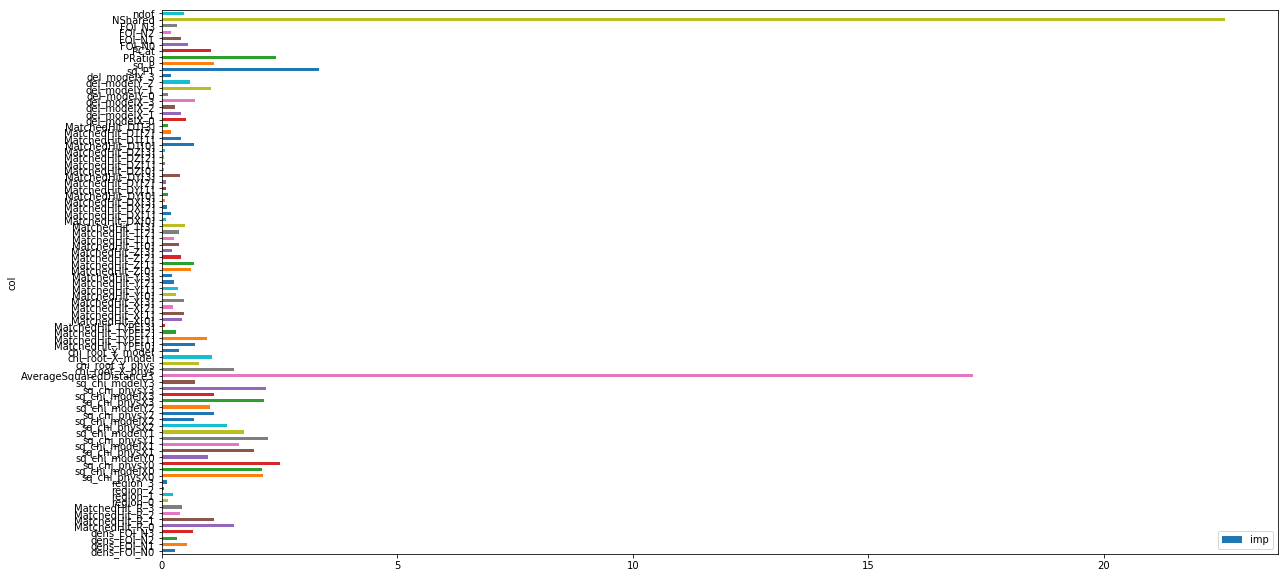

In [313]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X_train.columns})
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

## モデル保存

In [314]:
modelname = "Cat_20190209_3"
modeldir="./"

In [315]:
model.save_model(modeldir + '/' + modelname + ".cbm")
model.save_model(modeldir + '/' + modelname + ".pkl")

## 提出

In [116]:
test.head()

ncl[0]  ncl[1]  ncl[2]  ncl[3]  avg_cs[0]  avg_cs[1]  avg_cs[2]  \
id                                                                    
0       55      12      10      15   2.127273   1.166667   1.500000   
1       43      18      12      15   2.697674   1.111111   1.333333   
2       90      34      19      29   1.800000   2.058824   1.210526   
3      141      43      15      16   4.609929   2.744186   1.466667   
4       22      18       8       9   1.636364   2.444444   1.000000   

    avg_cs[3]  ndof  MatchedHit_TYPE[0]  MatchedHit_TYPE[1]  \
id                                                            
0    1.600000     8                   2                   2   
1    1.600000     8                   2                   2   
2    1.344828     8                   2                   2   
3    1.125000     8                   2                   2   
4    1.555556     8                   2                   2   

    MatchedHit_TYPE[2]  MatchedHit_TYPE[3]  MatchedHit_X[0]  MatchedHit_X[1]  \
id                                                                             
0                    2                   2        -22.33000         13.76000   
1                    2                   2      -1070.45500      -1156.07500   
2                    2                   2      -3348.08000      -3614.30000   
3                    1                   2       -213.62167       -238.30833   
4                    1                   1       -446.33835       -496.34167   

    MatchedHit_X[2]  MatchedHit_X[3]  MatchedHit_Y[0]  MatchedHit_Y[1]  \
id                                                                       
0          60.00000          65.7200      -1849.33730      -1833.79680   
1       -1202.87000       -1286.0700       -222.24156       -240.82657   
2       -3848.97000       -4113.1700      -1628.13240      -1758.31680   
3        -258.33667        -293.3700        483.45386        520.71850   
4        -550.00336        -588.4033        264.65280        284.41754   

    MatchedHit_Y[2]  MatchedHit_Y[3]  MatchedHit_Z[0]  MatchedHit_Z[1]  \
id                                                                       
0       -1968.07280      -2102.56400        15396.441        16404.695   
1        -258.19052       -274.01960        15117.299        16321.432   
2       -1887.17990      -2014.60830        15112.236        16315.968   
3         559.30420        663.87054        15119.840        16324.174   
4         305.50333        328.02402        15203.053        16407.324   

    MatchedHit_Z[2]  MatchedHit_Z[3]  MatchedHit_DX[0]  MatchedHit_DX[1]  \
id                                                                         
0         17597.812        18806.229         12.750000         13.750000   
1         17514.170        18722.213          6.375000          6.875000   
2         17508.303        18715.945         25.500000         27.500000   
3         17517.113        18926.592          3.208333          3.458333   
4         17600.200        18808.380          3.208333          3.458333   

    MatchedHit_DX[2]  MatchedHit_DX[3]  MatchedHit_DY[0]  MatchedHit_DY[1]  \
id                                                                           
0          59.000000         63.000000         63.078957         68.078926   
1          29.500000         31.500000         31.479162         33.979145   
2         118.000000        126.000000        126.278550        136.278490   
3          14.833333         31.500000         15.679264         16.929256   
4          14.833333         15.833333         15.679264         16.929256   

    MatchedHit_DY[2]  MatchedHit_DY[3]  MatchedHit_DZ[0]  MatchedHit_DZ[1]  \
id                                                                           
0          73.078896         78.078860         33.727364         33.745370   
1          36.479130         38.979115         33.613575         33.622578   
2         146.278410        156.278350         33.954950         33.99096

In [ ]:
test.describe()

In [316]:
test_selected = test[FEATURE_COLUMNS2]

In [ ]:
test_selected.head()

In [238]:
modelname = "Cat_20190209_3"
modeldir="../models"
#modeldir="../../IDAO-2019-muon-id/submit3"

In [241]:
model_read = joblib.load(modeldir + '/' + modelname + ".pkl")

In [331]:
#predictions = model.predict_proba(test_selected)[:,1]
predictions = model.predict_proba(X_train)[:,1]

In [332]:
submissionname = "Cat_20190209_3_train"
#submissionname = "Cat_20190209_3"
submissiondir = "./"

In [333]:
#pd.DataFrame(data={"prediction":predictions}, index=test_selected.index).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=utils.ID_COLUMN)

pd.DataFrame(data={"prediction":predictions}, index=X_train.index).to_csv(submissiondir + '/' + submissionname + ".csv", index_label=utils.ID_COLUMN)
